# Weighted average predictions
A prediction with expert advice is done considering
1. A decision space $\cal D$,
2. an outcome space $\cal y$,
3. A loss function $\ell$, and
4. a set of $\cal E$ of experts indices

For each round $t=1,2,\ldots$
1. The environment chooses the next outcome $y_t$ and the expert advice $\{f_{e,t} \in {\cal D}: e \in {\cal E}\}$;
2. The forecaster chooses the prediction $\hat{p}_t \in {\cal D}$;
3. The environmente reveals the next outcome $y_t \in {\cal Y}$;
4. the forecaster incurs loss $\ell(\hat p_t, y_t)$ and each expert $e$ incurs loss $\ell(f_{e,t}, y_t)$j

In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from plgx import datasets
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"

### Regret
The forecaster's goal is to keep as small as possible cumulative regret. For expert $e$, this quantity is defined by

$$
    R_{e,T} = \sum_{t=1}^T\left(\ell(\hat p_t, y_t)  - \ell(f_{e, t}, y_t)\right) = \hat L_T - L_{e, T}.
$$


### The weighted average forecaster
(A forecaster based on the potential $\Phi$)  
Using the notion of potential function, we give the following definition of the weighted average forecaster

$$
    \hat p_t = \frac{\sum_{e=1}^E \nabla\Phi(R_{t-1})_e f_{e,t}}{\sum_{e=1}^E \nabla\Phi(R_{t-1})_e}
$$

### Polynomially-weighted average forecaster

We consider the polynomially-weighted average forecaster based on the potential

$$
    \Phi_p({\bf u}) = \left(\sum_{e=1}^E (u_e)_+^p\right)^{2/p} = ||{\bf u}||_{p}^2
$$

Although $\nabla\Phi_p$ is relatively straighforward to compute, we make use of `jax.grad` for simplicity.

In [3]:
def loss(yhat, y):
    return (yhat - y) ** 2

def potential(x, p):
    xhat = jnp.maximum(0, x)
    return jnp.linalg.norm(xhat, p) ** 2

@partial(jax.vmap, in_axes=(0, 0, None), out_axes=-1)
def create_mistakes(key, p, T):
    mistakes = jax.random.bernoulli(key, p=p, shape=(T,))
    return mistakes


gradp = jax.grad(potential)

In [4]:
def forecast_step(experts_curr, regret_prev, pnorm):
    weights = gradp(regret_prev, pnorm)
    forecast = weights @ experts_curr / weights.sum()
    return forecast

def get_inst_regret(forecast, experts, oracle):
    """
    Update the regret of each agent and the instantaneous regret
    """
    inst_regret = loss(forecast, oracle) - loss(experts, oracle)
    inst_regret_forecaster = loss(forecast, oracle) - loss(experts, oracle).min()
    return inst_regret, inst_regret_forecaster


def step(regret, xs, pnorm):
    """
    At time t, we make a prediction based on the
    regret (as defined by the potential) obtained at time
    t-1 and the prediction of each forecaster at time t.

    After making a new prediction, we update the regret.
    """
    experts, oracle = xs
    forecast = forecast_step(experts, regret, pnorm)

    loss_forecaster = loss(forecast, oracle)
    loss_experts = loss(experts, oracle)

    iregret_experts = loss_forecaster - loss_experts
    regret_new = regret + iregret_experts

    res = {
        "forecast": forecast,
        "step-loss-experts": loss_experts,
        "step-loss-forecaster": loss_forecaster,
    }

    
    return regret_new, res

## Evaluating the forecaster
### Creating *stream* of data

In this example, we consider an oracle that takes decisions according to $y_t \sim \text{Bern}(\mu)$. We consider `n_experts` number of experts.  Each expert $e$ is correct $v_e \sim \text{Beta}(a, b)$ proportion of times.

## Experts

In [107]:
key = jax.random.PRNGKey(314)

n_experts = 20
n_timesteps = 5_000
a, b = 2, 7
p_oracle = 0.5
pnorm = 2
oracle, experts = datasets.bern_oracle_beta_forecasters(key, n_experts, n_timesteps, a, b, p_oracle)

In [108]:
regret = jnp.ones(n_experts)
xs = (experts, oracle)
part_step = partial(step, pnorm=pnorm)
_, res = jax.lax.scan(part_step, regret, xs)

In [109]:
L_experts = res["step-loss-experts"].cumsum(axis=0)
L_expert_min = L_experts.min(axis=1)
L_forecaster = res["step-loss-forecaster"].cumsum()

regret_forecaster = L_forecaster - L_expert_min

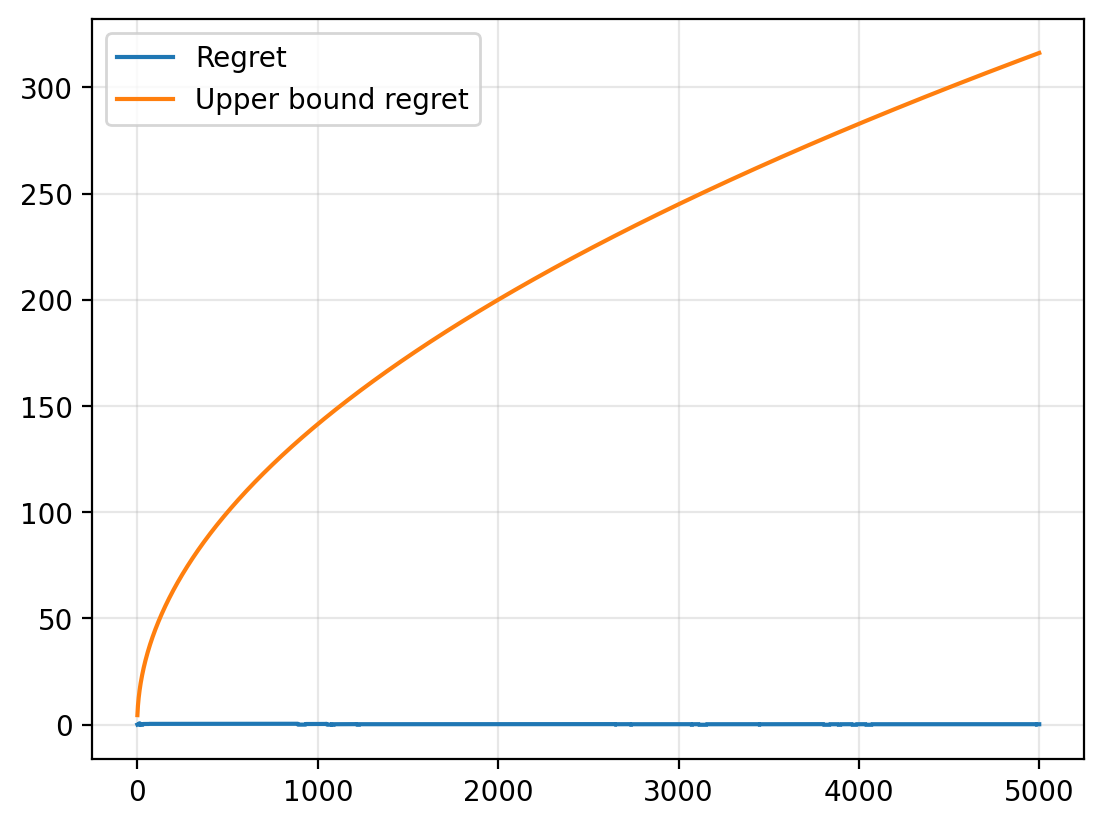

In [110]:
timesteps = np.arange(1, n_timesteps + 1)
ubound = np.sqrt(timesteps * (pnorm - 1) * n_experts ** (2 / pnorm))

plt.plot(regret_forecaster, label="Regret")
plt.plot(ubound, label="Upper bound regret")
plt.legend()
plt.grid(alpha=0.3)

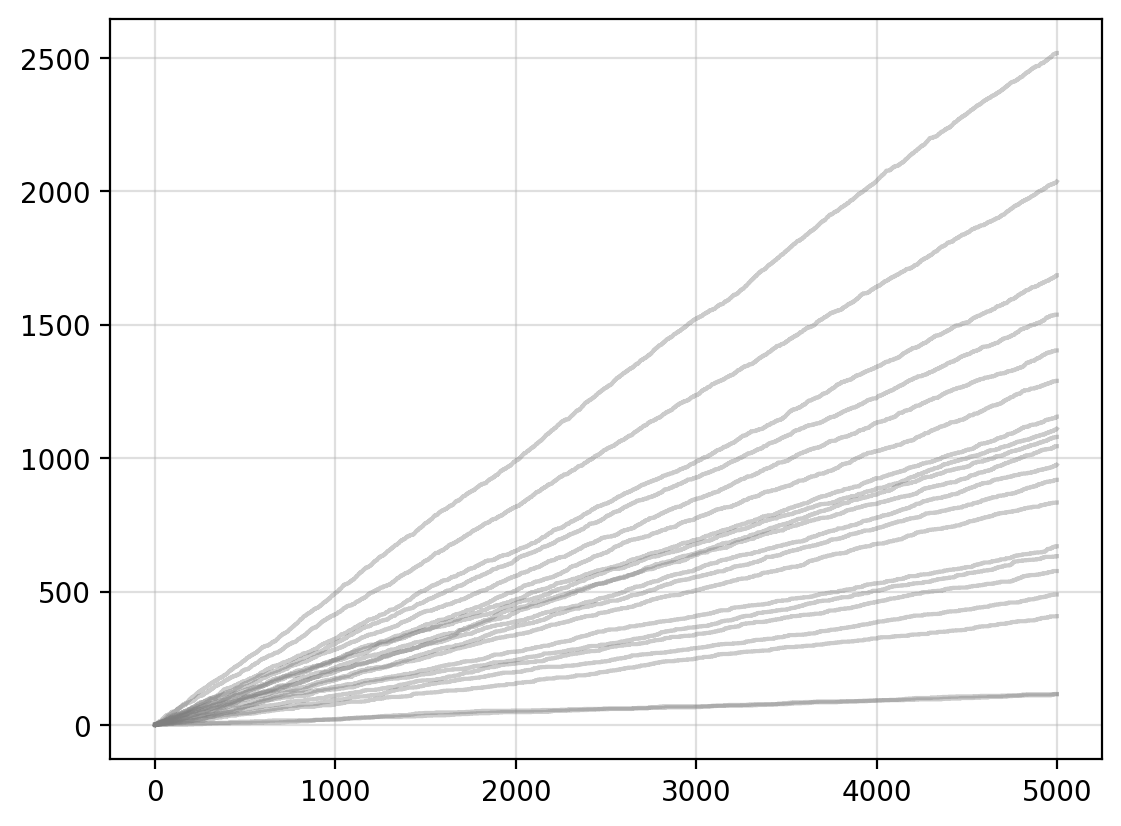

In [111]:
plt.plot(L_experts, c="tab:gray", alpha=0.4)
plt.grid(alpha=0.4);

## Test 02: Regime-changing context
In this example, each agent is correct with probability $v_{e,r} \sim \text{Beta}(a, b)$, where $a_t$ and $b_t$ are sampled from a hidden Markov process (HM)

In [112]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

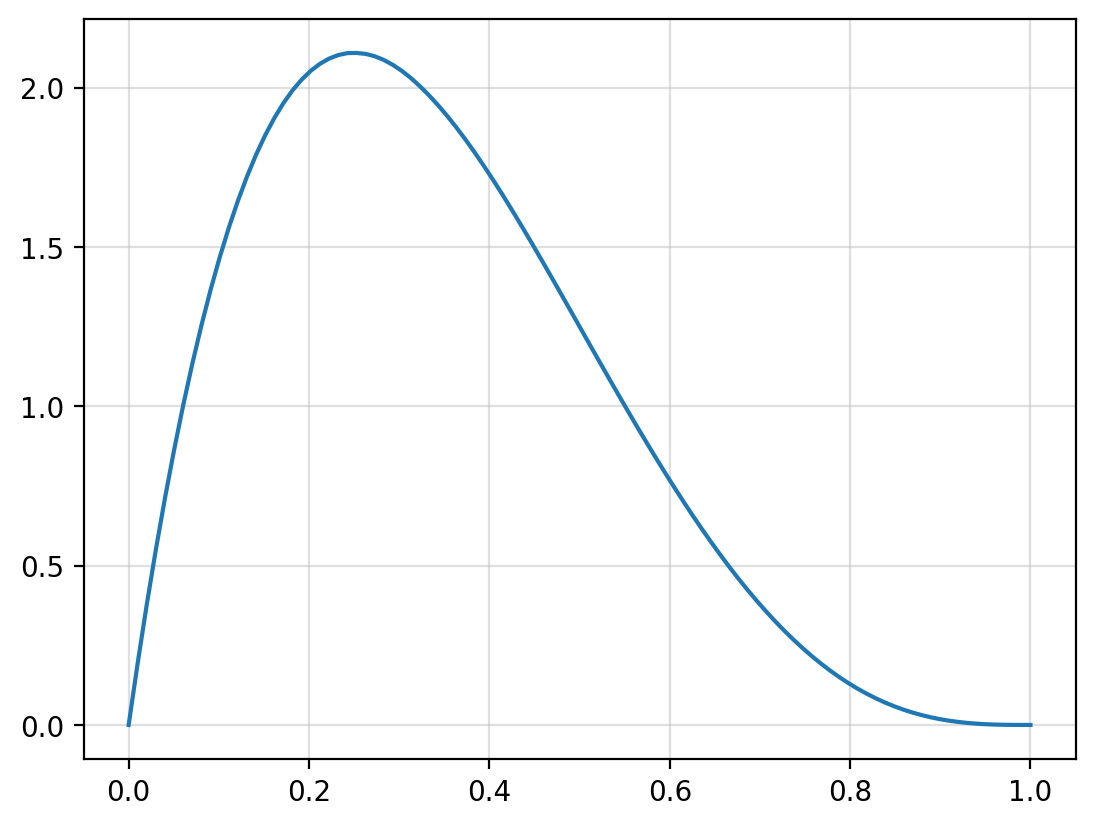

In [113]:
a, b = 2, 4
p_err = tfd.Beta(a, b)

x_err = jnp.linspace(0, 1, 100)
plt.plot(x_err, p_err.prob(x_err))
plt.grid(alpha=0.4)

In [136]:
key = jax.random.PRNGKey(314)


n_experts = 20
regimes = 5
n_timesteps_regime = 100
n_timesteps = regimes * n_timesteps_regime


# True oracle. Doesn't change
key_oracle, key_agent = jax.random.split(key)
oracle = jax.random.bernoulli(key_oracle, p=0.5, shape=(n_timesteps,))

mistakes = []
probas_mistakes = []
for i in range(regimes):
    keyi = jax.random.fold_in(key_agent, i)
    key_experts, key_noise, key_errs = jax.random.split(keyi, 3)
    keys_noise = jax.random.split(key_noise, n_experts)

    # Probability of a possible mistake
    ps_mistakes = jax.random.beta(key_errs, a=a, b=b, shape=(n_experts,))
    mistakes_regime = create_mistakes(keys_noise, ps_mistakes, n_timesteps_regime)
    probas_mistakes.append(ps_mistakes)
    mistakes.append(mistakes_regime)

probas_mistakes = jnp.stack(probas_mistakes, axis=0)
mistakes = jnp.concatenate(mistakes, axis=0)
experts = (mistakes ^ oracle[:, None]).astype(float)

In [137]:
%%time

pnorm = 2
regret = jnp.ones(n_experts)
xs = (experts, oracle)
part_step = partial(step, pnorm=pnorm)
_, res = jax.lax.scan(part_step, regret, xs)
res = jax.tree_map(np.array, res)

CPU times: user 147 ms, sys: 0 ns, total: 147 ms
Wall time: 106 ms


In [138]:
L_experts = res["step-loss-experts"].cumsum(axis=0)
L_expert_min = L_experts.min(axis=1)
L_forecaster = res["step-loss-forecaster"].cumsum()

regret_forecaster = L_forecaster - L_expert_min

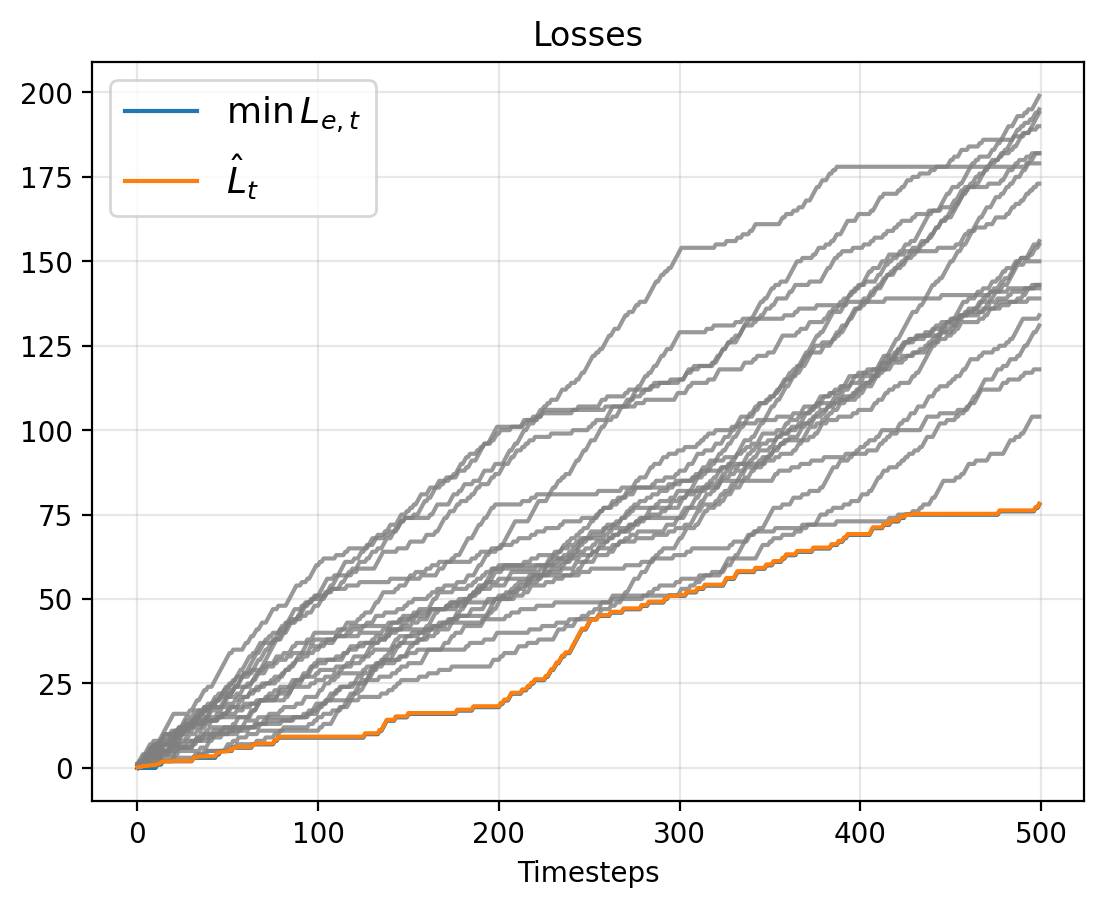

In [139]:
plt.plot(L_experts, c="tab:gray", alpha=0.8)
plt.plot(L_expert_min, label=r"$\min\,L_{e,t}$")
plt.plot(L_forecaster, label=r"$\hat L_t$")
plt.title("Losses")
plt.legend(fontsize=13)
plt.xlabel("Timesteps")
plt.grid(alpha=0.3)

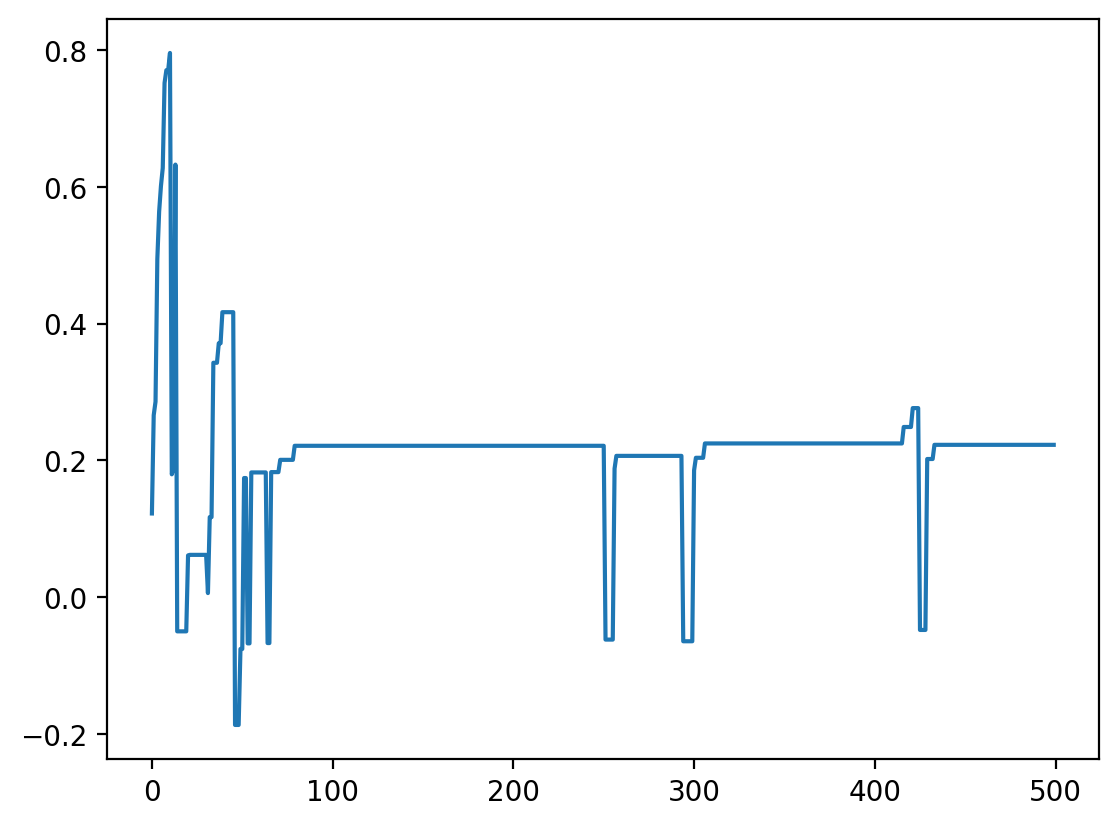

In [140]:
plt.plot(regret_forecaster)

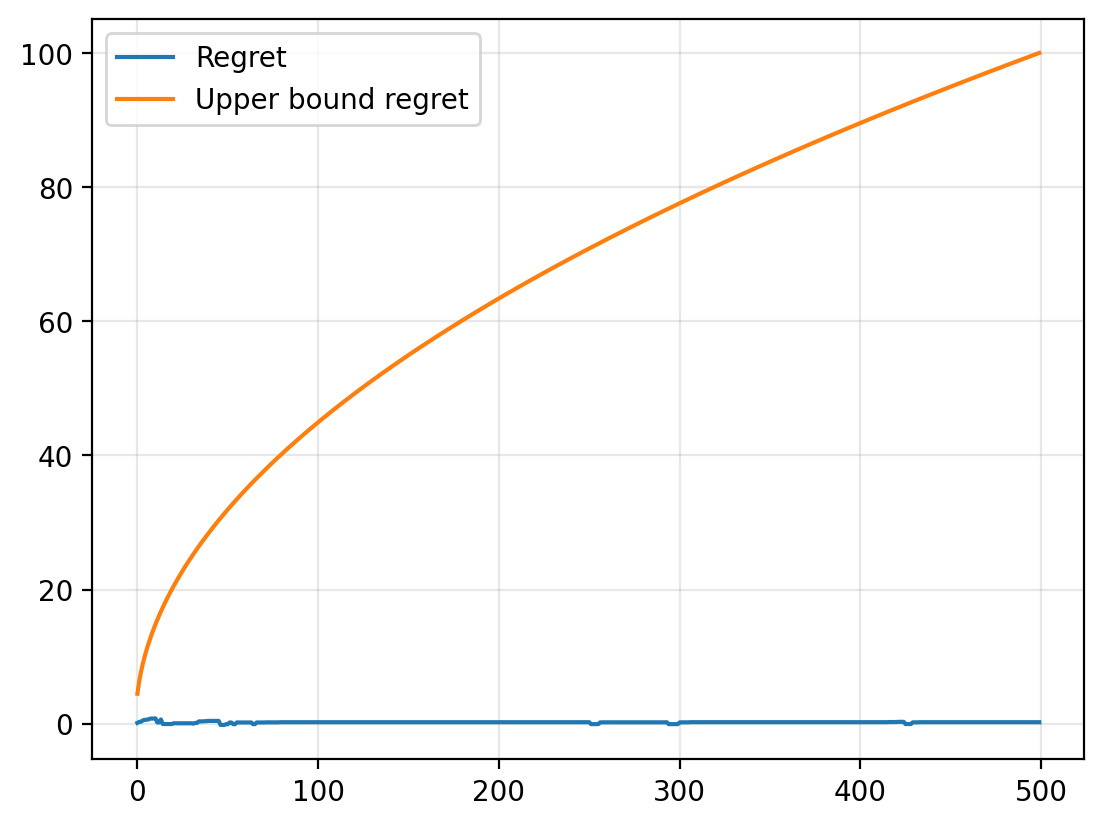

In [141]:
timesteps = np.arange(1, n_timesteps + 1)
ubound = np.sqrt(timesteps * (pnorm - 1) * n_experts ** (2 / pnorm))

plt.plot(regret_forecaster, label="Regret")
plt.plot(ubound, label="Upper bound regret")
plt.legend()
plt.grid(alpha=0.3)

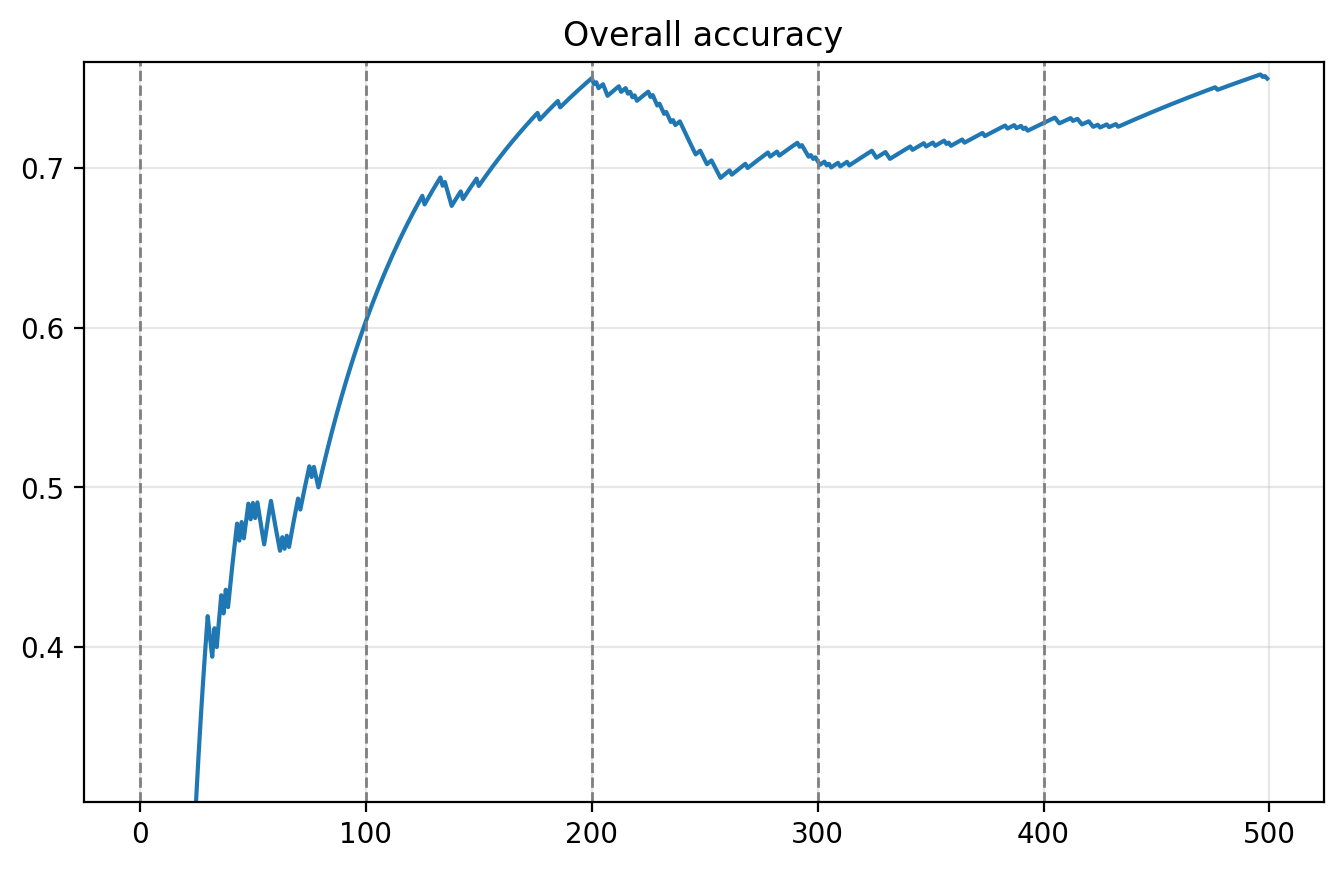

In [142]:
forecast = res["forecast"]

fig, ax = plt.subplots(figsize=(8, 4.8))
rolling_acc = (forecast == np.array(oracle)).cumsum() / jnp.arange(1, n_timesteps + 1)
plt.plot(rolling_acc)
for i in range(regimes):
    plt.axvline(i * n_timesteps_regime, c="tab:gray", linewidth=1, linestyle="--")
# plt.grid(alpha=0.4)
vmin = jnp.quantile(rolling_acc, 0.05) * 0.99
vmax = jnp.quantile(rolling_acc, 1.0) * 1.01
plt.ylim(vmin, vmax)
plt.title("Overall accuracy")
plt.grid(alpha=0.3)

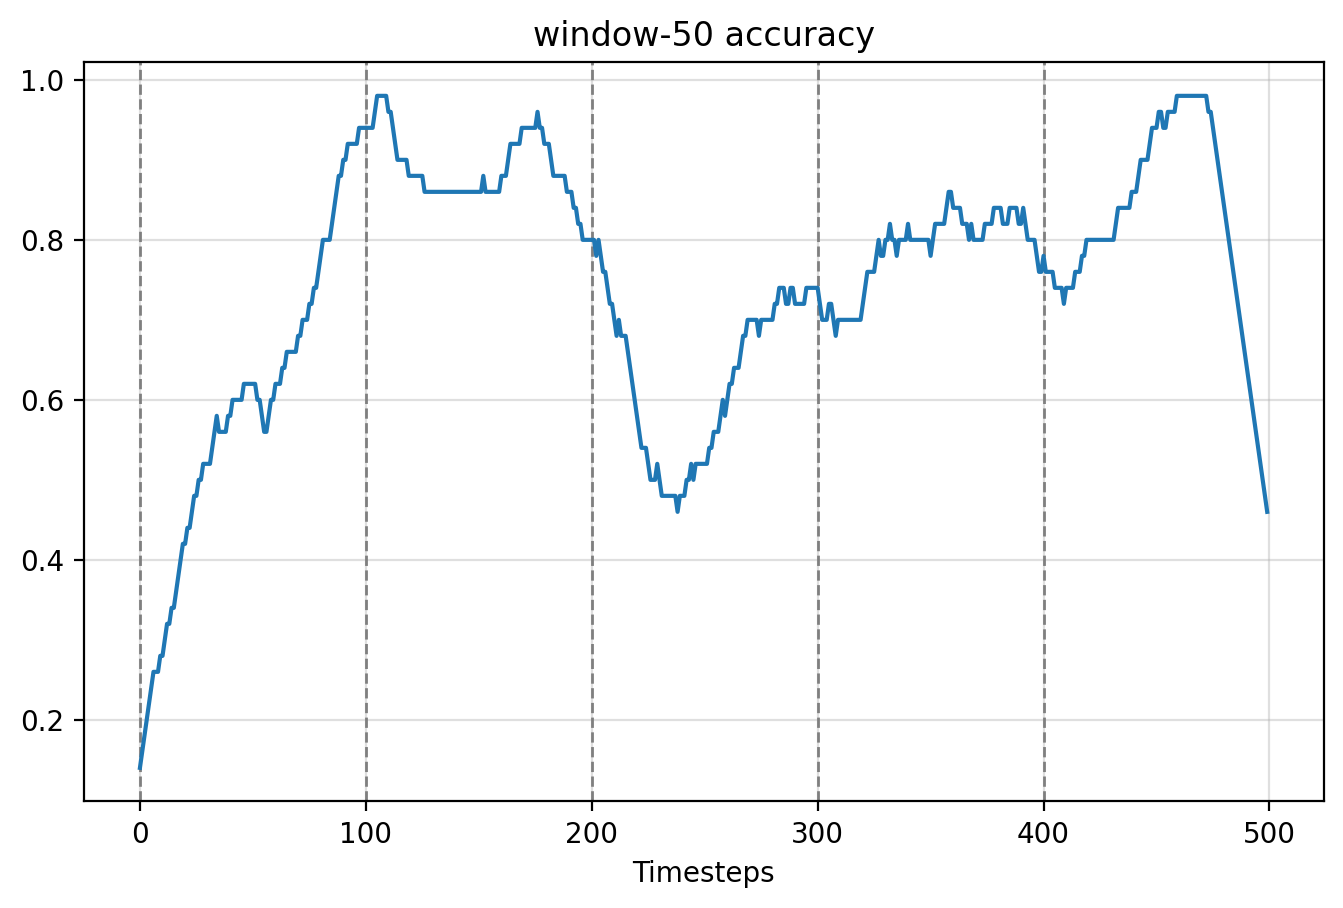

In [144]:
fig, ax = plt.subplots(figsize=(8, 4.8))
window_size = 50
window = np.ones(window_size) / window_size
evals = np.array(forecast == oracle)

for i in range(regimes):
    plt.axvline(i * n_timesteps_regime, c="tab:gray", linewidth=1, linestyle="--")

window_acc = np.convolve(evals, window, mode="same")
plt.plot(window_acc)
plt.title(f"window-{window_size} accuracy")
plt.xlabel("Timesteps")
plt.grid(alpha=0.4)